In [2]:
# Import các thư viện cần thiết
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [3]:
# Đường dẫn tới các file dữ liệu
books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

In [4]:
# Đọc dữ liệu từ file 'BX-Books.csv'
df_books = pd.read_csv(
    books_filename,
    encoding="ISO-8859-1",  # Encoding phù hợp với file
    sep=";",               # Phân cách các cột trong file là dấu chấm phẩy
    header=0,              # Sử dụng dòng đầu tiên làm tiêu đề
    names=['isbn', 'title', 'author', 'year', 'publisher'],  # Tên các cột
    usecols=['isbn', 'title', 'author', 'year', 'publisher'],  # Chỉ giữ lại các cột cần thiết
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str', 'year': 'str', 'publisher': 'str'}
)

In [5]:
# Đọc dữ liệu từ file 'BX-Book-Ratings.csv'
df_ratings = pd.read_csv(
    ratings_filename,
    encoding="ISO-8859-1",  # Encoding phù hợp với file
    sep=";",               # Phân cách các cột
    header=0,              # Sử dụng dòng đầu tiên làm tiêu đề
    names=['user', 'isbn', 'rating'],  # Tên các cột
    usecols=['user', 'isbn', 'rating'],  # Chỉ giữ lại các cột cần thiết
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'}
)

In [6]:
# Hiển thị thông tin ban đầu của dữ liệu
df_books.head()  # Xem trước một số dòng của dữ liệu sách

,isbn,title,author,year,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [7]:
df_ratings.head()  # Xem trước một số dòng của dữ liệu đánh giá

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


In [8]:
df_books.info()  # Xem thông tin tổng quan về dataframe sách

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   isbn       271379 non-null  object
 1   title      271379 non-null  object
 2   author     271377 non-null  object
 3   year       271379 non-null  object
 4   publisher  271377 non-null  object
dtypes: object(5)
memory usage: 10.4+ MB


In [9]:
df_ratings.info()  # Xem thông tin tổng quan về dataframe đánh giá

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   user    1149780 non-null  int32  
 1   isbn    1149780 non-null  object 
 2   rating  1149780 non-null  float32
dtypes: float32(1), int32(1), object(1)
memory usage: 17.5+ MB


# Xử lý dữ liệu

In [10]:
# Chuyển cột year thành số. errors='coerce': Giá trị không thể chuyển đổi sẽ bị thay thành NaN (giá trị trống).
df_books['year'] = pd.to_numeric(df_books['year'], errors='coerce')

In [11]:
# Lọc các sách có năm xuất bản hợp lệ (từ 1950 đến 2024)
df_books_cleaned = df_books[(df_books['year'] >= 1950) & (df_books['year'] <= 2024)]

# Đếm số sách xuất bản theo từng năm
yearly_counts = df_books_cleaned['year'].value_counts().sort_index()

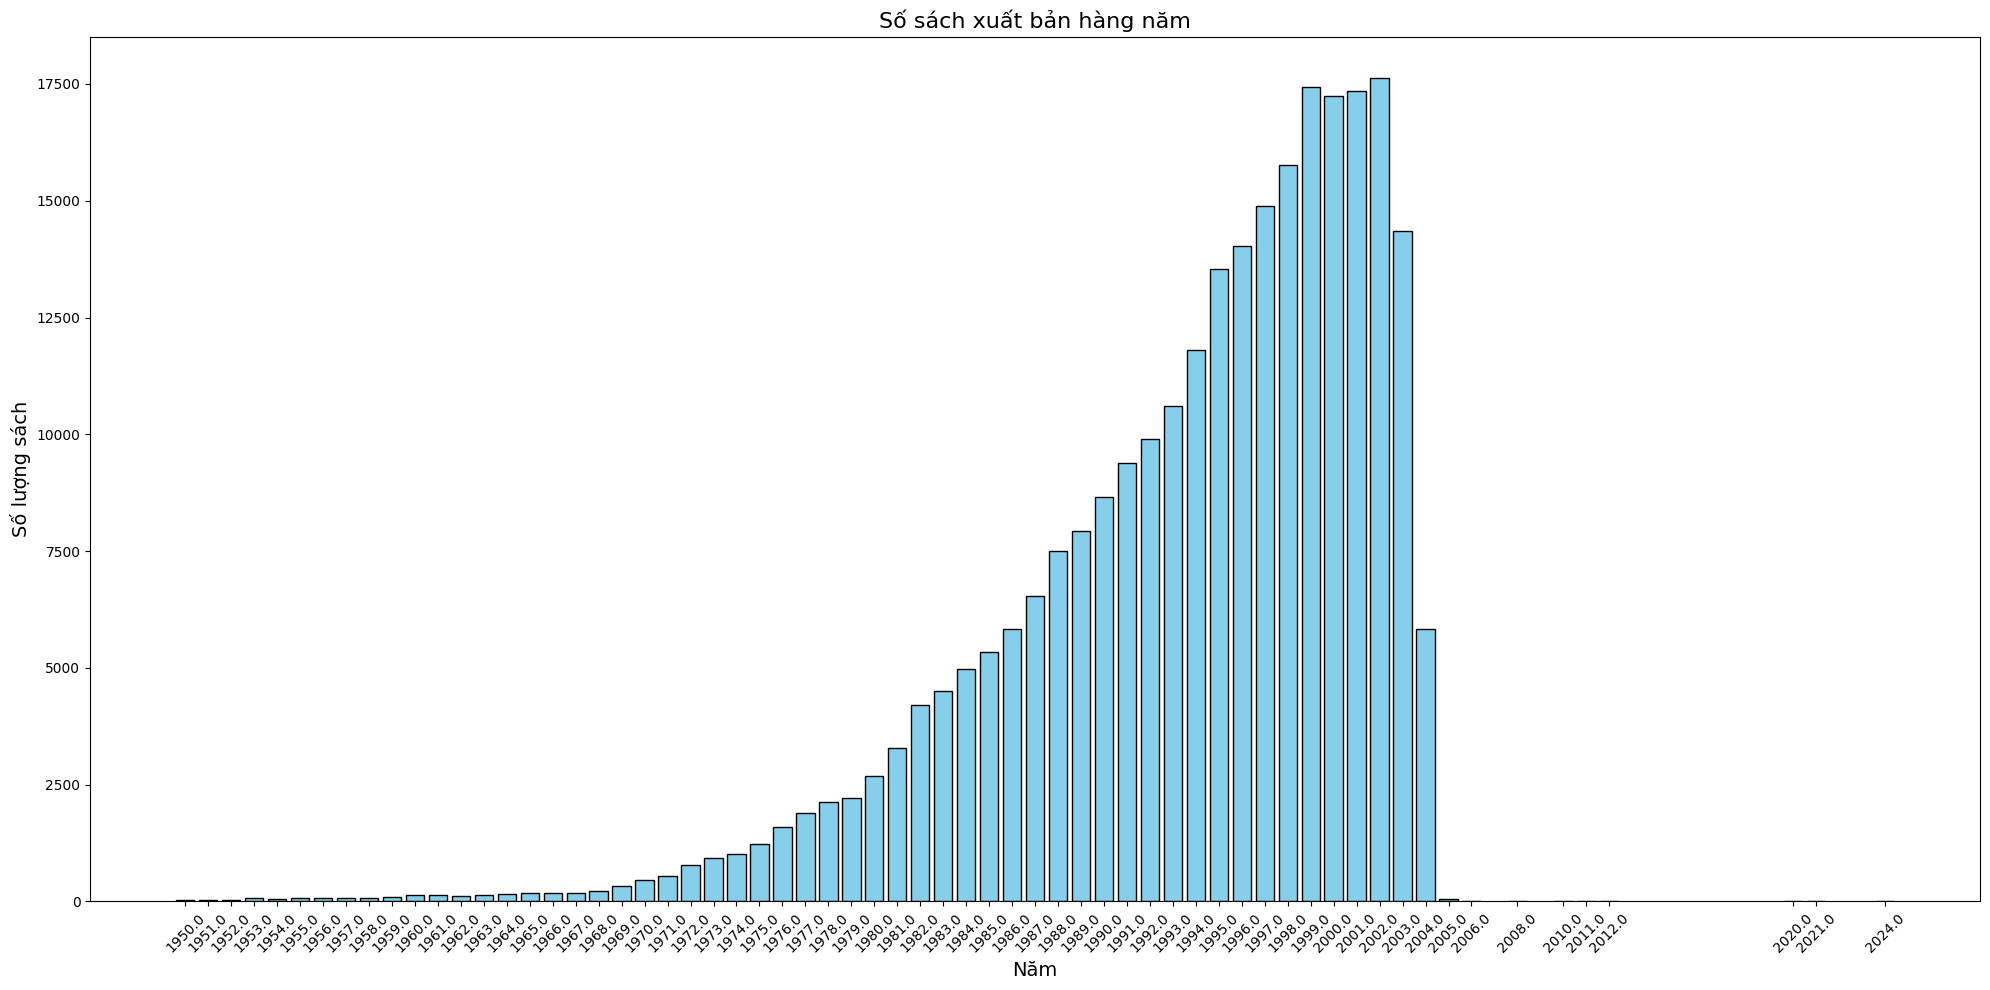

In [12]:
# Vẽ biểu đồ số lượng sách xuất bản theo năm
plt.figure(figsize=(20, 10))
plt.bar(yearly_counts.index, yearly_counts.values, color='skyblue', edgecolor='black')
plt.title('Số sách xuất bản hàng năm', fontsize=16)
plt.xlabel('Năm', fontsize=14)
plt.ylabel('Số lượng sách', fontsize=14)
plt.xticks(ticks=yearly_counts.index, labels=yearly_counts.index, fontsize=10, rotation=45)
plt.tight_layout()
plt.show()

In [13]:
# Lọc dữ liệu đánh giá
df_ratings.user.unique()  # Kiểm tra số lượng người dùng

# Lọc dữ liệu để giữ lại người dùng có ít nhất 200 đánh giá và sách có ít nhất 100 lượt đánh giá
counts1 = df_ratings['user'].value_counts()  # Đếm số đánh giá của mỗi người dùng
counts2 = df_ratings['isbn'].value_counts()  # Đếm số lượt đánh giá cho mỗi sách

In [14]:
df = df_ratings[
    ~df_ratings['user'].isin(counts1[counts1 < 200].index)  # Giữ người dùng >= 200 đánh giá
]
df = df[
    ~df['isbn'].isin(counts2[counts2 < 100].index)  # Giữ sách >= 100 lượt đánh giá
]

# Kết hợp dữ liệu sách và đánh giá qua mã 'isbn'
df = pd.merge(right=df, left=df_books, on="isbn")

# Loại bỏ các bản ghi trùng lặp theo 'title' và 'user'
df = df.drop_duplicates(["title", "user"])

In [15]:
# Kiểm tra dữ liệu sau khi lọc người dùng và sách
print("Số lượng người dùng và sách còn lại sau khi lọc:")
print(f"- Số lượng người dùng: {df['user'].nunique()}")
print(f"- Số lượng sách: {df['isbn'].nunique()}")

# Hiển thị các bản ghi đầu tiên để kiểm tra
print("\nDữ liệu sau khi lọc:")
print(df.head())


Số lượng người dùng và sách còn lại sau khi lọc:
- Số lượng người dùng: 888
- Số lượng sách: 727

Dữ liệu sau khi lọc:
         isbn          title        author    year publisher    user  rating
0  0440234743  The Testament  John Grisham  1999.0      Dell  277478     0.0
1  0440234743  The Testament  John Grisham  1999.0      Dell    2977     0.0
2  0440234743  The Testament  John Grisham  1999.0      Dell    3363     0.0
3  0440234743  The Testament  John Grisham  1999.0      Dell    7346     9.0
4  0440234743  The Testament  John Grisham  1999.0      Dell    9856     0.0


In [16]:
# Tạo ma trận pivot: mỗi dòng là một sách, mỗi cột là một người dùng
piv = df.pivot(index='title', columns='user', values='rating').fillna(0)

# Chuyển ma trận pivot thành numpy array để tính toán
matrix = piv.values

In [17]:
# Hiển thị thông tin ma trận pivot
print("\nMa trận pivot sau khi lọc (5 hàng đầu tiên):")
print(piv.head())

# Kích thước của ma trận pivot
print(f"\nKích thước ma trận pivot: {piv.shape}")



Ma trận pivot sau khi lọc (5 hàng đầu tiên):
user                                                254     2276    2766    \
title                                                                        
1984                                                   9.0     0.0     0.0   
1st to Die: A Novel                                    0.0     0.0     0.0   
2nd Chance                                             0.0    10.0     0.0   
4 Blondes                                              0.0     0.0     0.0   
A Beautiful Mind: The Life of Mathematical Geni...     0.0     0.0     0.0   

user                                                2977    3363    4017    \
title                                                                        
1984                                                   0.0     0.0     0.0   
1st to Die: A Novel                                    0.0     0.0     0.0   
2nd Chance                                             0.0     0.0     0.0   
4 Blondes        

| Title                  | User 1 | User 2 | User 3 | User 4 |
|------------------------|--------|--------|--------|--------|
| Harry Potter           | 5.0    | 0.0    | 4.0    | 0.0    |
| Lord of the Rings      | 4.0    | 5.0    | 0.0    | 0.0    |
| The Catcher in the Rye | 0.0    | 3.0    | 0.0    | 4.0    |


# Phương pháp 1: Cosine Similarity

### Công thức tính Cosine Similarity:
\[
\text{Cosine Similarity} = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}
\]

---

### Ví dụ: Tính Cosine Similarity giữa Book A và Book C

#### Vector biểu diễn:
- **Book A**: \([5, 0, 3, 0]\)
- **Book C**: \([2, 0, 1, 0]\)

#### Tính tích vô hướng:
\[
\mathbf{A} \cdot \mathbf{B} = (5 \times 2) + (0 \times 0) + (3 \times 1) + (0 \times 0) = 10 + 0 + 3 + 0 = 13
\]

#### Tính độ lớn vector:
\[
\|\mathbf{A}\| = \sqrt{5^2 + 0^2 + 3^2 + 0^2} = \sqrt{25 + 9} = \sqrt{34}
\]
\[
\|\mathbf{B}\| = \sqrt{2^2 + 0^2 + 1^2 + 0^2} = \sqrt{4 + 1} = \sqrt{5}
\]

#### Tính Cosine Similarity:
\[
\text{Cosine Similarity} = \frac{13}{\sqrt{34} \times \sqrt{5}} \approx 0.99
\]

---

### Kết quả: Ma trận Cosine Similarity

|          | Book A | Book B | Book C | Book D | Book E |
|----------|--------|--------|--------|--------|--------|
| **Book A** | 1.00   | 0.00   | 0.99   | 0.00   | 0.50   |
| **Book B** | 0.00   | 1.00   | 0.00   | 0.98   | 0.00   |
| **Book C** | 0.99   | 0.00   | 1.00   | 0.00   | 0.40   |
| **Book D** | 0.00   | 0.98   | 0.00   | 1.00   | 0.00   |
| **Book E** | 0.50   | 0.00   | 0.40   | 0.00   | 1.00   |

---

### Tìm sách tương tự:

- Nếu người dùng muốn gợi ý sách cho **Book A**, hệ thống chọn các sách có điểm tương đồng cao nhất (trừ Book A):
  - **Book C** (0.99)
  - **Book E** (0.50)

#### Gợi ý cuối cùng:
- **Sách gợi ý cho Book A**: **Book C**, **Book E**.


In [18]:
# Tính ma trận cosine similarity giữa các sách
cosine_sim_matrix = cosine_similarity(piv.values)

In [19]:
# Hàm gợi ý sách dựa trên Cosine Similarity, hiển thị thêm tên tác giả
def get_recommends_cosine(book=""):
    if book not in piv.index:  # Kiểm tra xem sách có tồn tại trong dữ liệu không
        print(f"Rất tiếc, cuốn sách '{book}' không có trong cơ sở dữ liệu của chúng tôi. Dưới đây là 5 gợi ý ngẫu nhiên:")
        # Gợi ý 5 cuốn sách ngẫu nhiên
        random_books = random.sample(list(piv.index), 5)
        for rb in random_books:
            # Lấy thông tin tác giả từ df_books
            author = df_books[df_books['title'] == rb]['author'].values
            author_info = author[0] if len(author) > 0 else "Không rõ"
            print(f"- {rb}, tác giả {author_info}")
        return None

    # Lấy chỉ số của cuốn sách trong ma trận
    book_idx = piv.index.get_loc(book)

    # Tính toán độ tương đồng giữa cuốn sách được chọn và các cuốn khác
    sim_scores = list(enumerate(cosine_sim_matrix[book_idx]))
    # Sắp xếp sách theo điểm tương đồng (từ cao đến thấp)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]  # Chọn 5 sách có độ tương đồng cao nhất (trừ chính nó)

    print(f"5 cuốn sách gợi ý cho '{book}' dựa trên độ tương đồng Cosine:")
    for sim_idx, sim_score in sim_scores:
        # Lấy tiêu đề của cuốn sách gợi ý
        recommended_title = piv.index[sim_idx]

        # Lấy tên tác giả từ df_books
        author = df_books[df_books['title'] == recommended_title]['author'].values
        author_info = author[0] if len(author) > 0 else "Không rõ"

        # Hiển thị kết quả
        print(f"- {recommended_title}, tác giả {author_info} ({1-sim_score:.5f})")


In [20]:
get_recommends_cosine("The Fellowship of the Ring (The Lord of the Rings, Part 1)")

5 cuốn sách gợi ý cho 'The Fellowship of the Ring (The Lord of the Rings, Part 1)' dựa trên độ tương đồng Cosine:
- The Return of the King (The Lord of the Rings, Part 3), tác giả J.R.R. TOLKIEN (0.75255)
- The Two Towers (The Lord of the Rings, Part 2), tác giả J.R.R. TOLKIEN (0.75267)
- Bee Season: A Novel, tác giả Myla Goldberg (0.81751)
- The Tale of the Body Thief (Vampire Chronicles (Paperback)), tác giả Anne Rice (0.82962)
- Fahrenheit 451, tác giả Ray Bradbury (0.83404)


# Phương pháp 2: K-Nearest Neighbors (KNN)

In [21]:
# Tạo mô hình KNN dựa trên cosine distance
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [22]:
# Hàm gợi ý sách dựa trên thuật toán K-Nearest Neighbors
def get_recommends(book=""):
    if book not in piv.index:  # Kiểm tra sách có tồn tại trong dữ liệu không
        print(f"Rất tiếc, cuốn sách '{book}' không có trong cơ sở dữ liệu của chúng tôi. Dưới đây là 5 gợi ý ngẫu nhiên:")
        # Gợi ý 5 cuốn sách ngẫu nhiên
        random_books = random.sample(list(piv.index), 5)
        for rb in random_books:
            # Lấy tên tác giả từ df_books
            author = df_books[df_books['title'] == rb]['author'].values
            author_info = author[0] if len(author) > 0 else "Không rõ"
            print(f"- {rb} của tác giả {author_info}")
        return None

    # Vector đại diện cho cuốn sách
    book_vector = piv.loc[book].values.reshape(1, -1)

    # Tìm 5 hàng xóm gần nhất (dựa trên khoảng cách Cosine)
    distances, indices = model_knn.kneighbors(book_vector, n_neighbors=6)

    print(f"5 cuốn sách gợi ý cho '{book}' dựa trên thuật toán K-Nearest Neighbors:")
    for i in range(1, len(indices[0])):  # Bắt đầu từ 1 để bỏ qua chính sách đó
        # Lấy tiêu đề của sách gợi ý
        recommended_title = piv.index[indices[0][i]]

        # Lấy tên tác giả từ df_books
        author = df_books[df_books['title'] == recommended_title]['author'].values
        author_info = author[0] if len(author) > 0 else "Không rõ"

        # Hiển thị kết quả
        print(f"- {recommended_title}, tác giả {author_info} ({distances[0][i]:.5f})")


In [26]:
get_recommends("The Fellowship of the Ring (The Lord of the Rings, Part 1)")

5 cuốn sách gợi ý cho 'The Fellowship of the Ring (The Lord of the Rings, Part 1)' dựa trên thuật toán K-Nearest Neighbors:
- The Return of the King (The Lord of the Rings, Part 3), tác giả J.R.R. TOLKIEN (0.75255)
- The Two Towers (The Lord of the Rings, Part 2), tác giả J.R.R. TOLKIEN (0.75267)
- Bee Season: A Novel, tác giả Myla Goldberg (0.81751)
- The Tale of the Body Thief (Vampire Chronicles (Paperback)), tác giả Anne Rice (0.82962)
- Fahrenheit 451, tác giả Ray Bradbury (0.83404)


In [24]:
get_recommends("Harry Potter and the Order of the Phoenix (Book 5)")

5 cuốn sách gợi ý cho 'Harry Potter and the Order of the Phoenix (Book 5)' dựa trên thuật toán K-Nearest Neighbors:
- Harry Potter and the Goblet of Fire (Book 4), tác giả J. K. Rowling (0.45375)
- Harry Potter and the Prisoner of Azkaban (Book 3), tác giả J. K. Rowling (0.53537)
- Harry Potter and the Chamber of Secrets (Book 2), tác giả J. K. Rowling (0.64433)
- Harry Potter and the Sorcerer's Stone (Book 1), tác giả J. K. Rowling (0.70840)
- Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)), tác giả J. K. Rowling (0.72714)


In [25]:
get_recommends("Harry Pottex (Book 5)")

Rất tiếc, cuốn sách 'Harry Pottex (Book 5)' không có trong cơ sở dữ liệu của chúng tôi. Dưới đây là 5 gợi ý ngẫu nhiên:
- The Plains of Passage (Earth's Children (Paperback)) của tác giả JEAN M. AUEL
- One for the Money (A Stephanie Plum Novel) của tác giả Janet Evanovich
- The Secret Life of Bees của tác giả Sue Monk Kidd
- Midwives: A Novel của tác giả Chris Bohjalian
- Catch 22 của tác giả Joseph Heller
